# Выполнил
Кабиров Ирик <br>
Резюме ссылки: 
- https://ufa.hh.ru/resume/87314315ff091df0fb0039ed1f506848353144 
- https://www.linkedin.com/in/irik-kabirov-abb688132/

Контакты:
- irik.kabirov@yandex.ru
- https://t.me/KabiroivIrik

На вакнсию откликнулся  резюме "Data scientist / Data-аналитик"
<br>
github: https://github.com/KabirovIrik

# Тестовое задание:
Было запущено 2 рекламные компании одного и того же продукта.<br>
Первые результаты были следующими:<br>
- среди мужской аудитории было 3000 показов рекламы и 130 кликов<br>
- среди женской аудитории было 980 показов и 50 кликов<br>

Можно ли с вероятностью 95% утверждать, что в дальнейшем конверсия среди <br> женской аудитории будет выше, чем среди мужской.<br>

# Решение

## Краткий обзор
Взглянем на доли кликов: общую и по обеим аудиториям  

In [1]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.power as power
import pandas as pd
import matplotlib.pylab as plt
import  random

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
males = 3000
male_click = 130
male_no_click = males - male_click
male_prop = np.round(100*male_click/males, 2)

females = 980
female_click = 50
female_no_click = females - female_click
female_prop = np.round(100*female_click/females, 2)

total_views = males + females
total_no_click = male_no_click + female_no_click
total_clicks = male_click + female_click
total_prop = np.round(100*total_clicks/total_views, 2)

print(f"Доля кликов мужской аудитории:\t{male_prop}%")
print(f"Доля кликов женской аудитории:\t{female_prop}%")
print(f"Доля кликов общая:\t\t{total_prop}%")
print()
print(f"Кликов males аудитории:\t\t{males}")
print(f"Кликов женской аудитории:\t{females}")
print()
print(f"Всего прсмотров:\t\t{total_views}")
print(f"Всего кликов:\t\t\t{total_clicks}")
print(f"Всего НЕкликов:\t\t\t{total_no_click}")



Доля кликов мужской аудитории:	4.33%
Доля кликов женской аудитории:	5.1%
Доля кликов общая:		4.52%

Кликов males аудитории:		3000
Кликов женской аудитории:	980

Всего прсмотров:		3980
Всего кликов:			180
Всего НЕкликов:			3800


Наблюдаемая конверсия женской аудитории больше конверсий общей и мужской аудитории <br>
Формулируем гипотезы:
- Нулевая гипотеза $H_0$: разница между конверсиями вызвана случайностью и не значима.
- Альтернативная гипотеза $H_1$: доля кликов женской аудитории больше мужской (односторонний критерий), т.е. разница между конверсиями не случайна и статистически значима.  

Проведем два теста, чтобы сделать вывод и отвергнуть одну из гипотез:
- Перестановочный тест
- Проверка Хи-квадрат

## Мощность теста
Рассчитаем вероятность отклонить нулевую гипотезу с текущим количеством данных

In [3]:
# Размер эффекта - разность между долями кликов
effect_size = sm.stats.proportion_effectsize(female_click/females, male_click/males)
# уровень значимости
alpha = .05

zpower = power.NormalIndPower()

# Соотношение групп
ratio = females/males

# Мощность для двух групп
stat_power = np.round(100*zpower.power(effect_size, males, alpha, ratio=ratio, alternative='larger'), 2)

# Размер одной группы для 95% мощности
sample_size = zpower.solve_power(effect_size=effect_size, power=.95, alpha=alpha, ratio=1)

print(f'Текущая мощность: \t\t{stat_power}%')
print(f'Размер группы для 95% мощности:\t{np.int(sample_size)}')

Текущая мощность: 		25.51%
Размер группы для 95% мощности:	19738


## Перестановочный тест
С помощью перестановочного теста узнаем: как часто наблюдаемая разница долей кликов может произойти случайным образом
<br>
План:
- Создадим общую выборку просмотров, которая будет состоять из нулей и единиц, где 0 - клика не было, 1 - клик был
- Много раз (например, 1000) выполним следующий цикл:
  - Из общей выборки создаем две новые выборки (муж. и жен. аудитории). Для этого возьмем без возврата 3000 элементов для мужской аудитории и 980 - для женской.
  - Посчитаем и сохраним разницу между долями кликов мужской и женской аудиторий
- Из сохраненных разниц создаем гистограмму
- Строим 95% доверительный интервал. Т.к. критерий односторонний, то берем границы между квантилями от 0 и 0.95
- Смотрим где находится наблюдаемая разница

Наблюдаемая разница конверсий: 0.77%
Границы доверительного 95%-го интервала: [-2.0741496598639455, 1.310204081632653]


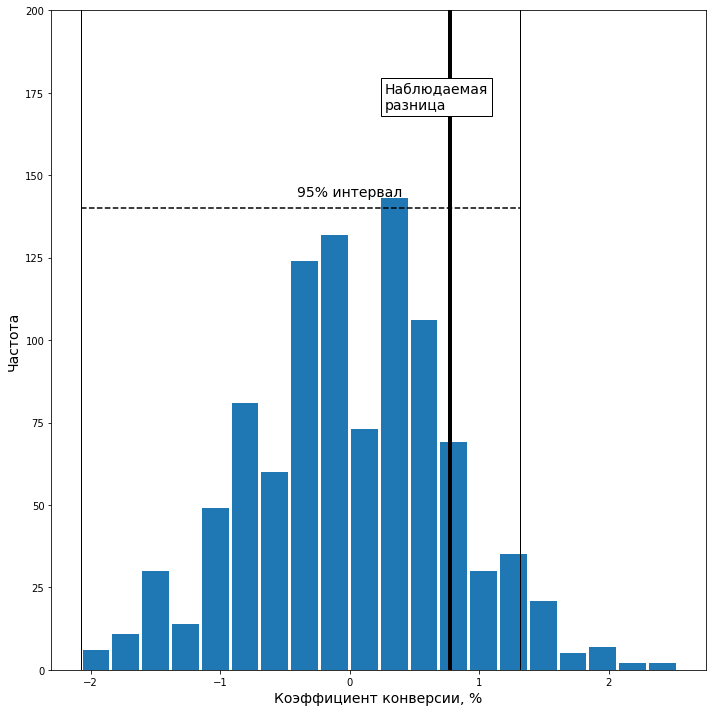

In [4]:
random.seed(42) # зафиксируем для воспроизводимости результата

# Функция получения разниц конверсий между двух выборок
def permSets(x, nA, nB):
  """
  x  - общая выборка 
  nA - количество элементов в 1-й выборке
  nB - количество элементов во 2-й выборке
  """
  # Получаем общее количество элементов
  n = nA + nB

  # Получаем случайно индексы для 2-й выборки
  idx_B = set(random.sample(range(n), nB))
  # Получаем оставшиеся индексы для 1-й выборки
  idx_A = set(range(n)) - idx_B

  # Находим доли кликов
  mean_a = x.loc[idx_A].mean()
  mean_b = x.loc[idx_B].mean()

  # Возвращаем разницу
  return mean_b - mean_a

obs_diff = female_prop - male_prop
print(f'Наблюдаемая разница конверсий: {obs_diff:.2f}%')

# Общая выборка
conversion = [0] * total_no_click + [1] * total_clicks
conversion = pd.Series(conversion)

# Получение списка разниц между ауидториями
perm_diffs = np.array([100 * permSets(conversion, males, females) for _ in range(1000)])
# Значения доверительного интервала
confidence_interval = list(pd.Series(perm_diffs).quantile([0.0, 0.95]))
print("Границы доверительного 95%-го интервала:", confidence_interval)

# Отрисовка графика
fig, ax = plt.subplots(figsize=(10, 10))

# Гистограмма
ax.hist(perm_diffs, bins=20, rwidth=0.9)

# Границы доверительного интервала
ax.axvline(x=confidence_interval[0], color='black', lw=1)
ax.axvline(x=confidence_interval[1], color='black', lw=1)
ax.plot(confidence_interval, [140, 140], '--', color='black')
ax.text(0, 145, '95% интервал', horizontalalignment='center', verticalalignment='center', fontsize=14)

# Наблюдаемая разница
ax.axvline(x=obs_diff, color='black', lw=4)
ax.text(obs_diff-.5, 170, 'Наблюдаемая\nразница', bbox={'facecolor':'white'}, fontsize=14)

ax.set_xlabel('Коэффициент конверсии, %', fontsize=14)
ax.set_ylabel('Частота', fontsize=14)
ax.set_ylim(0, 200)

plt.tight_layout()
plt.show()

Наблюдамая разница находится внутри диапазона доверительного интервала, т.е. можно сказать, что разница вызвана случайностью

## Проверка Хи-квадрат

In [5]:
# Таблица сопряженности
contingency_table = np.array([
    [male_click, male_no_click], 
    [female_click, female_no_click]
])


# Вычисление значений
chi2, p_value, df, _ = stats.chi2_contingency(contingency_table)
single_side = p_value / 2# делим попалам для одностороннего критерия
print(f'p-value: {single_side:.4f}') 

if single_side < alpha:
  print('Отклоняем нулевую гипотезу')
else:
  print('Отклоняем альтернативную гипотезу')


p-value: 0.1796
Отклоняем альтернативную гипотезу


# Вывод
- Мощность теста 25% - это низкий показатель (необходимо больше показов). 
- Но на данный момент это не важно, так как тесты показали, что стоит отклонить альтернативную гипотезу, т.к. наблюдаемая разница конверсий скорее всего вызвана случайностью